In [8]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from utils.inspect_utils import *
from models.attriclip_utils.model import CoOp
from models.attriclip_utils.utils import *

device = torch.device('cuda:0')

In [9]:
job_id = '7ee62bb5-8fc3-4b4b-ad83-b0d05ac7b8a4'
task_id = 7

In [10]:
args = load_checkpoint_args('/home/aba/mar/aimagelab', job_id)
args = Namespace(**args)

In [11]:
net = CoOp(False, False, args)
net.init_model(class_names=cifar100_classes[10*task_id:10*(task_id+1)], text_key=net.text_key, text_prompt=net.text_prompt)

In [12]:
print(net.load_state_dict(torch.load(f'/home/aba/mar/aimagelab/attriclip_{task_id}_{job_id}.pt')))

<All keys matched successfully>


In [13]:
net.clip_model.token_embedding

Embedding(49408, 768)

In [14]:
from clip.simple_tokenizer import SimpleTokenizer
tokenizer = SimpleTokenizer()
tokenizer.encoder

{'!': 0,
 '"': 1,
 '#': 2,
 '$': 3,
 '%': 4,
 '&': 5,
 "'": 6,
 '(': 7,
 ')': 8,
 '*': 9,
 '+': 10,
 ',': 11,
 '-': 12,
 '.': 13,
 '/': 14,
 '0': 15,
 '1': 16,
 '2': 17,
 '3': 18,
 '4': 19,
 '5': 20,
 '6': 21,
 '7': 22,
 '8': 23,
 '9': 24,
 ':': 25,
 ';': 26,
 '<': 27,
 '=': 28,
 '>': 29,
 '?': 30,
 '@': 31,
 'A': 32,
 'B': 33,
 'C': 34,
 'D': 35,
 'E': 36,
 'F': 37,
 'G': 38,
 'H': 39,
 'I': 40,
 'J': 41,
 'K': 42,
 'L': 43,
 'M': 44,
 'N': 45,
 'O': 46,
 'P': 47,
 'Q': 48,
 'R': 49,
 'S': 50,
 'T': 51,
 'U': 52,
 'V': 53,
 'W': 54,
 'X': 55,
 'Y': 56,
 'Z': 57,
 '[': 58,
 '\\': 59,
 ']': 60,
 '^': 61,
 '_': 62,
 '`': 63,
 'a': 64,
 'b': 65,
 'c': 66,
 'd': 67,
 'e': 68,
 'f': 69,
 'g': 70,
 'h': 71,
 'i': 72,
 'j': 73,
 'k': 74,
 'l': 75,
 'm': 76,
 'n': 77,
 'o': 78,
 'p': 79,
 'q': 80,
 'r': 81,
 's': 82,
 't': 83,
 'u': 84,
 'v': 85,
 'w': 86,
 'x': 87,
 'y': 88,
 'z': 89,
 '{': 90,
 '|': 91,
 '}': 92,
 '~': 93,
 '¡': 94,
 '¢': 95,
 '£': 96,
 '¤': 97,
 '¥': 98,
 '¦': 99,
 '§': 100

In [15]:
reverse_tokens = {v: k for k, v in tokenizer.encoder.items()}

In [16]:
for i in range(10):
    print('----- PROMPT {} -----'.format(i))
    ret = F.cosine_similarity(net.model.prompt_learner.text_prompt[i].unsqueeze(1).cpu().detach(), net.clip_model.token_embedding.weight.unsqueeze(0).cpu().detach(), dim=-1)
    values, indices = ret.topk(3, largest=True)
    for idx in indices:
        words = [reverse_tokens[x.item()] for x in idx]
        print(words)

----- PROMPT 0 -----
['dur', 'notice</w>', 'packed</w>']
['cleve', 'aby', 'barefoot</w>']
['ender</w>', 'boc', 'gag</w>']
['boards</w>', 'ott', 'speci']
['crusaders</w>', 'businesses</w>', 'annan</w>']
['µ', 'ather</w>', 'linn</w>']
['dogrescue</w>', 'shortfilm</w>', 'bsf</w>']
['mags</w>', 'lis', 'storians</w>']
['ðŁĩºðŁĩ¸ðŁĩºðŁĩ¸ðŁĩºðŁĩ¸</w>', 'ceremonial</w>', 'economics</w>']
['resolution</w>', 'spectre</w>', 'mercur']
['reopened</w>', 'durability</w>', 'arson</w>']
['statistics</w>', 'ðŁİŁï¸ı</w>', 'âľįï¸ı</w>']
----- PROMPT 1 -----
['reys</w>', 'munro</w>', 'ðŁĮı</w>']
['alou', 'buck', 'dvn</w>']
['ived</w>', 'intentional</w>', 'mercen']
['tait</w>', 'tians</w>', 'neuro</w>']
['imp', 'branding</w>', 'hood</w>']
['blasio</w>', 'abz</w>', 'prose</w>']
['Â·</w>', 'nbl</w>', 'bombshell</w>']
['dali', 'antebellum</w>', 'alexander']
['nathan</w>', 'nate', 'ingley</w>']
['uof', 'fex</w>', 'cpi</w>']
['snyder</w>', 'vmware</w>', 'venue</w>']
['ceremon', 'notic', 'å¥']
----- PROMPT 2 ----

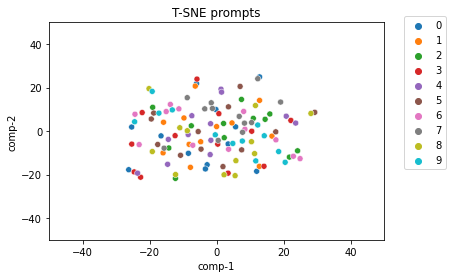

In [30]:
import pandas as pd
from sklearn.manifold import TSNE

x = net.model.prompt_learner.text_prompt.view(10*12, 768).cpu().detach().numpy()
y = torch.arange(10).unsqueeze(1).repeat(1, 12).view(-1).detach().numpy()

ret = TSNE(perplexity=5).fit_transform(x)

df = pd.DataFrame()
df['y'] = y
df["comp-1"] = ret[:,0]
df["comp-2"] = ret[:,1]

plt.xlim(-50, 50)
plt.ylim(-50, 50)

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("tab10", 10),
                data=df).set(title="T-SNE prompts")

plt.legend(bbox_to_anchor=(1.2, 1.05))

In [20]:
ret.shape

torch.Size([49408])